# Data processing and visualization lab
## Python project
Joan Altés Depares

Feb 2020
___________________________

### Import modules

In [1]:
import numpy as np
import pandas as pd
import tabula
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.palettes import Spectral
#from bokeh.palettes import brewer

### Loading data
We use `pandas` for loading `xlsx` and `csv`, `tabula` for `pdf`.

In [3]:
#Import Cleveland data (CSV)
data_clev=pd.read_csv('processed.cleveland.data',header=None) 

#Import Hungary and Switzerland data (xlsx), first column being the label
data_hung=pd.read_excel('Hungarian_Switzerland.xlsx','Hungarian Data',index_col=0) 
data_swit=pd.read_excel('Hungarian_Switzerland.xlsx','Switzerland Data',index_col=0)

#Import Long Beach data (pdf)
data_long=tabula.read_pdf('LongBeachData.pdf',pages='all',pandas_options={'header':None})

### Preparing data
Data from `excel` is ready to go, we just need to add the hospital column. Data from `pdf` requires as well that first column and first row are set as labels. Data from `csv` requires to create row labels. All datasets are assigned the same header (retrieved from hungary data) and merged together and then hospital column is moved to first spot. Some columns are renamed to remove innecessary spaces. Finally, the dataset is saved in csv format.

In [6]:
data_hung['hospital']='HU' #add column with hospital
data_swit['hospital']='SW'

In [5]:
data_long=pd.concat(data_long) #concatenate all pdf pages
data_long['hospital']='LB' #add hospital
data_long=data_long.set_index(data_long.columns[0]) #turn first column into label
data_long.columns=data_hung.columns.values #put same header as other data
data_long=data_long.drop(data_long.index[0]) #remove first row (corresponding to header, not a patient)

In [7]:
data_clev['hospital']='CL' #add hospital
data_clev.columns=data_hung.columns.values #add header 
data_clev['patient']=['Patient '+str(i+1) for i in range(len(data_clev))] #create a column with patient numbers
data_clev=data_clev.set_index('patient') #turn patient column into label

In [8]:
data=pd.concat([data_long,data_clev,data_swit,data_hung]) #concatenate all data into a single dataframe
cols=data.columns.tolist() #put hospital variable to first column
data=data[cols[-1:]+cols[:-1]]
data=data.rename(columns={'age      ':'age','Chest pain type   ':'Chest pain type',
                         'ST depression ':'ST depression','thal  ':'thal','diagnosis of heart disease ':'diagnosis of HD'})

In [7]:
data.to_csv(r'C:\Users\joana\OneDrive\Escriptori\LPDV\data_processed.csv') #save the merged dataset

In order to be able to work with the data it is necessary that numbers are either floats or integers, not strings. A function is created to see all data types present in each column, and it'll be used before changing columns (to check what needs to be done) and after (to make sure data is ready). We could also use the `dtype` method but columns with mixed types would appear as `object` without specifying. All columns are converted to integers except `hospital` which is string and `ST depression` which is float. 

In [15]:
def column_data_types(data): #function for displaying all data types in each column
    cols_types={} #initialize dictionary
    for column in data.columns.values: 
        data_types=[] #create a data type list
        for elem in data[column]: #for each column check all elements
            if type(elem) not in data_types: #if data type is new append it to the list
                data_types.append(type(elem))
        cols_types[column]=data_types #keys are columns and values are data types 
    return cols_types

In [16]:
column_data_types(data)

{'hospital': [str],
 'age': [str, int, float],
 'sex': [str, int, float],
 'Chest pain type': [str, int, float],
 'resting blood pressure': [str, float, int],
 'serum cholestoral': [str, int, float],
 'fasting blood sugar': [str, int, float],
 'Resting EEG': [str, int, float],
 'maximum heart rate': [str, float, int],
 'exercise induced angina': [str, float, int],
 'ST depression': [str, float, int],
 'slope ST': [str, float, int],
 'number of major vessels': [str, int],
 'thal': [str, int],
 'diagnosis of HD': [str, int]}

In [17]:
for column in data.columns.values: #iterate over columns
    
    #column hospital are strings so no changes needed
    if column=='hospital': 
        continue
        
    #columns in which there are no missing values can be directly converted to int
    elif column in ['age','sex','Chest pain type','diagnosis of HD']: 
        data[column]=data[column].apply(int)
    
    #missing values are replaced for nan (which are float), then data is converted to float and finally to integer 
    else:
        if column in ['resting blood pressure','serum cholestoral']: #in these columns zeros are actually nan
            data[column]=data[column].replace(['0',0],np.nan)
        data[column]=data[column].replace('?',np.nan) #? replaced with nan
        data[column]=data[column].apply(float) 
        if column=='ST depression': #this column is float
            continue
        data[column]=data[column].astype('Int64') #pandas allows to convert data with nans to int (nans are still float)

In [18]:
column_data_types(data)

{'hospital': [str],
 'age': [int],
 'sex': [int],
 'Chest pain type': [int],
 'resting blood pressure': [numpy.int64, float],
 'serum cholestoral': [numpy.int64, float],
 'fasting blood sugar': [numpy.int64, float],
 'Resting EEG': [numpy.int64, float],
 'maximum heart rate': [numpy.int64, float],
 'exercise induced angina': [numpy.int64, float],
 'ST depression': [float],
 'slope ST': [numpy.int64, float],
 'number of major vessels': [float, numpy.int64],
 'thal': [float, numpy.int64],
 'diagnosis of HD': [int]}

### Data visualization

Once all values are set as integer or float we can try to see the relationship between variables. Using `df.corr()` the correlation matrix between all columns is computed as another dataframe. The `style` method applies a heatmap to it for better visualization. Data can be separated using different criteria to see if correlations are consistent.

In [13]:
#apply heatmap to correlation matrix with two significant figures
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2) 

,age,sex,Chest pain type,resting blood pressure,serum cholestoral,fasting blood sugar,Resting EEG,maximum heart rate,exercise induced angina,ST depression,slope ST,number of major vessels,thal,diagnosis of HD
age,1,0.057,0.17,0.25,0.083,0.23,0.21,-0.37,0.2,0.26,0.16,0.37,0.14,0.34
sex,0.057,1,0.17,0.0056,-0.095,0.089,-0.016,-0.18,0.18,0.1,0.13,0.094,0.37,0.26
Chest pain type,0.17,0.17,1,0.024,0.096,0.04,0.031,-0.35,0.42,0.24,0.2,0.21,0.31,0.4
resting blood pressure,0.25,0.0056,0.024,1,0.089,0.16,0.096,-0.1,0.15,0.17,0.07,0.094,0.11,0.14
serum cholestoral,0.083,-0.095,0.096,0.089,1,0.056,0.065,-0.047,0.086,0.047,0.032,0.13,-0.0079,0.067
fasting blood sugar,0.23,0.089,0.04,0.16,0.056,1,0.13,-0.053,0.029,0.055,0.092,0.15,0.11,0.16
Resting EEG,0.21,-0.016,0.031,0.096,0.065,0.13,1,0.053,0.032,0.12,-0.015,0.14,-0.04,0.14
maximum heart rate,-0.37,-0.18,-0.35,-0.1,-0.047,-0.053,0.053,1,-0.36,-0.15,-0.36,-0.26,-0.33,-0.37
exercise induced angina,0.2,0.18,0.42,0.15,0.086,0.029,0.032,-0.36,1,0.39,0.32,0.13,0.34,0.39
ST depression,0.26,0.1,0.24,0.17,0.047,0.055,0.12,-0.15,0.39,1,0.42,0.28,0.25,0.44


In [14]:
#we can retrieve last column (most interesting one as it shows a first approach of variable predictive power
#last element of the column is excluded as it shows correlation of HD variable to itselft (1)
pd.DataFrame(data.corr()['diagnosis of HD'][:-1]).style.background_gradient(cmap='coolwarm').set_precision(2)

,diagnosis of HD
age,0.34
sex,0.26
Chest pain type,0.4
resting blood pressure,0.14
serum cholestoral,0.067
fasting blood sugar,0.16
Resting EEG,0.14
maximum heart rate,-0.37
exercise induced angina,0.39
ST depression,0.44


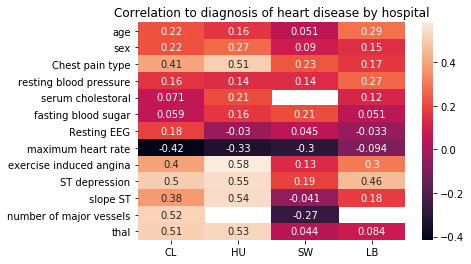

In [15]:
#Separate data by hospital and select last column of the correlation matrix
#Concatenate data from different hospitals by columns
#seaborn heatmap is used as it allows nans while pandas style method does not
sns.heatmap(pd.concat([data[data['hospital']=='CL'].corr()['diagnosis of HD'][:-1],
          data[data['hospital']=='HU'].corr()['diagnosis of HD'][:-1],
          data[data['hospital']=='SW'].corr()['diagnosis of HD'][:-1],
          data[data['hospital']=='LB'].corr()['diagnosis of HD'][:-1]],axis=1),annot=True,xticklabels=['CL','HU','SW','LB'])
plt.title('Correlation to diagnosis of heart disease by hospital')
plt.show()

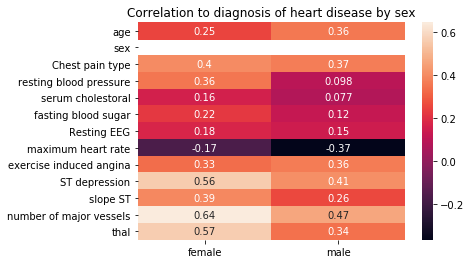

In [16]:
#Separate data by sex
sns.heatmap(pd.concat([data[data['sex']==0].corr()['diagnosis of HD'][:-1],
          data[data['sex']==1].corr()['diagnosis of HD'][:-1]],axis=1),annot=True,xticklabels=['female','male'])
plt.title('Correlation to diagnosis of heart disease by sex')
plt.show()

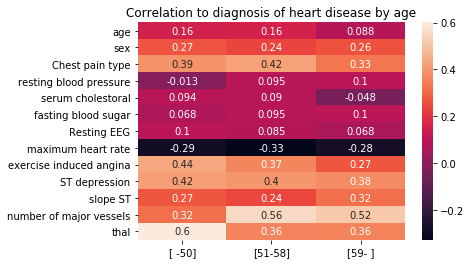

In [17]:
#Separate data by age. Thresholds are chosen considering percentils 33 and 66 so all groups have the same amount of data
th1=data['age'].quantile(q=0.33)
th2=data['age'].quantile(q=0.66)
sns.heatmap(pd.concat([data[data['age']<=th1].corr()['diagnosis of HD'][:-1],
          data[(data['age']>th1) & (data['age']<=th2)].corr()['diagnosis of HD'][:-1],
          data[data['age']>th2].corr()['diagnosis of HD'][:-1]],axis=1),annot=True,
            xticklabels=['[ -'+str(int(th1))+']','['+str(int(th1+1))+'-'+str(int(th2))+']','['+str(int(th2+1))+'- ]'])
plt.title('Correlation to diagnosis of heart disease by age')
plt.show()

Some nice plots to do are scatter matrices, in which correlations between all variables can be better visualized by scatter plots, which allows to visualise data class as well. Just to play a bit this is done by two different methods (`pandas.plotting.scatter_matrix` and `seaborn.pairplot`) using only continuous variables (which are nicer to visualize, but it could be applied to all of them).

<IPython.core.display.Javascript object>


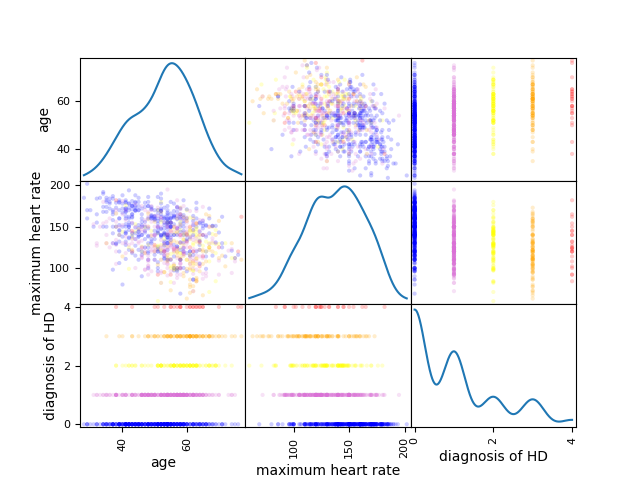

In [18]:
%matplotlib notebook
data_complete=data[['age','maximum heart rate', 'diagnosis of HD']].dropna() #it is necessary to remove nans for pandas method
for col in data_complete.columns.values:
    data_complete[col]=data_complete[col].apply(float) #numbers must be converted to float
colors_palette = {0: 'blue', 1: 'orchid', 2:'yellow',3:'orange',4:'red'} #we create a dictionary with desired color for each class
colors = [colors_palette[c] for c in data_complete['diagnosis of HD']] #create a color vector

#plot the scatter matrix, choosing in the diagonal a density distribuiton plot (other options such as histogram are available)
matrix_of_scatterplots = pd.plotting.scatter_matrix(data_complete, alpha=0.2,  color=colors, diagonal='density')
plt.show()

<IPython.core.display.Javascript object>


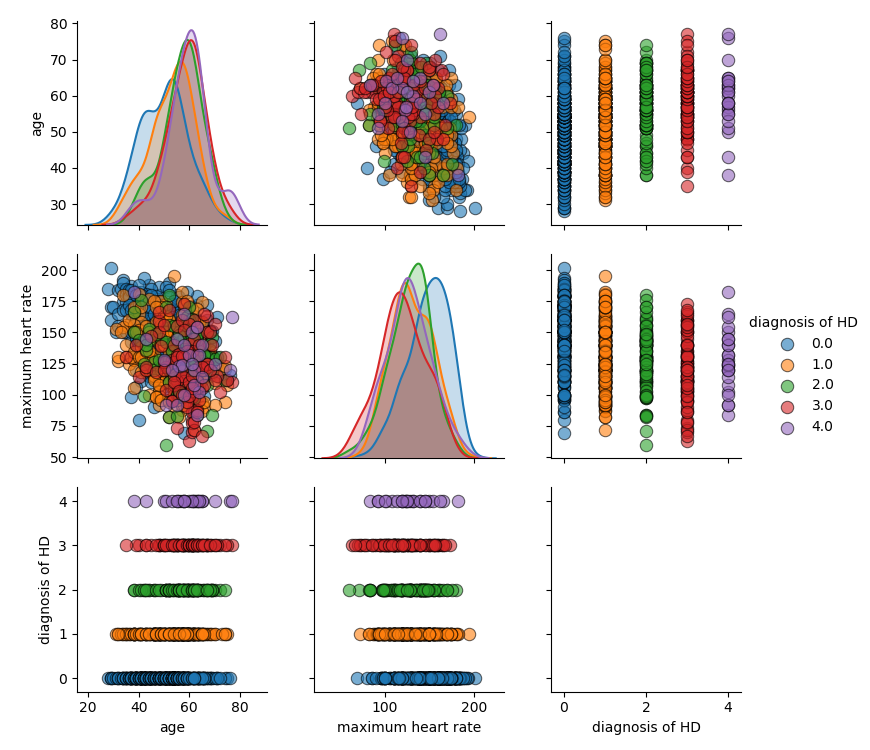

C:\Users\joana\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\joana\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


In [19]:
%matplotlib notebook
#Using seaborn plots are nicer, it disgregates the distribution by type plus it adds a legend
sns.pairplot(data_complete, hue = 'diagnosis of HD',diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})
plt.show()

Alternatively, we can use `seaborn.PairGrid` for more personalized options. In the following plot trend lines per class are added in the lower part of the grid and class distribution on the upper part. The diagonal shows distribution and histogram.

<IPython.core.display.Javascript object>


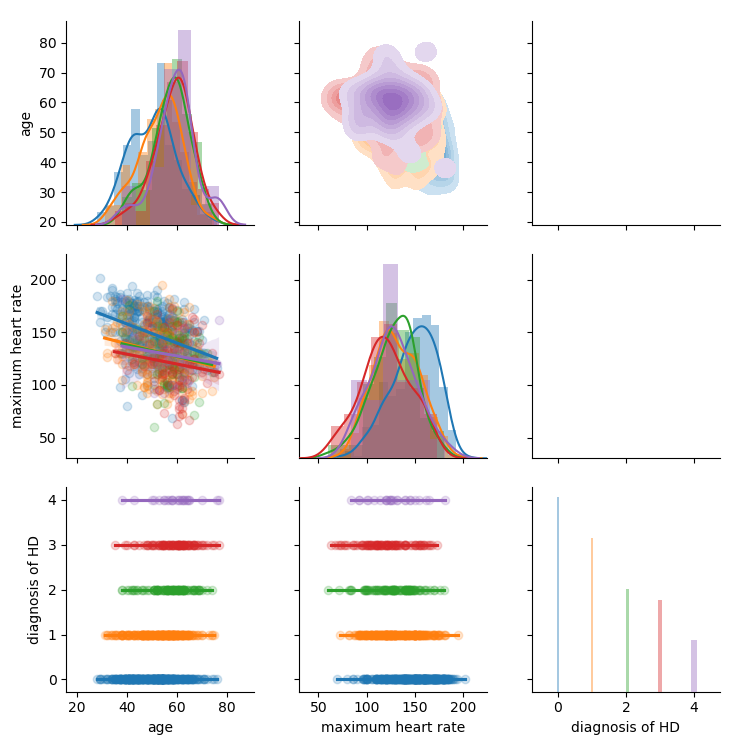

C:\Users\joana\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Users\joana\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\joana\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\joana\Anaconda3\lib\site-packages\matplotlib\contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
C:\Users\joana\Anaconda3\lib\site-packages\matplotlib\contour.py:1171: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]


In [20]:
%matplotlib notebook

g = sns.PairGrid(data_complete, hue="diagnosis of HD",diag_sharey=False) #define grid, diag_sharey is for proper y-scale in diag
g.map_diag(sns.distplot) 
g.map_lower(sns.regplot, truncate=True, scatter_kws=dict(alpha=0.2)) #regplot for trend lines
g.map_upper(sns.kdeplot,shade=True, shade_lowest=False) #kde plot for distributions

plt.show()

For further study we can disgregate by hospitals and see age influence on heart disease diagnosis. To do so, data is separated by age (in ten intervals obtained by computing percentils from 10 to 10) and by hospital. `maximum heart rate` correlation to `diagnosis of HD` is computed, stored on a dataframe and visualized using `seaborn`. This ensures that age partitions have overall the same number of patients (but this is not necessarly the case for each hospital).

C:\Users\joana\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]
C:\Users\joana\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.


<IPython.core.display.Javascript object>


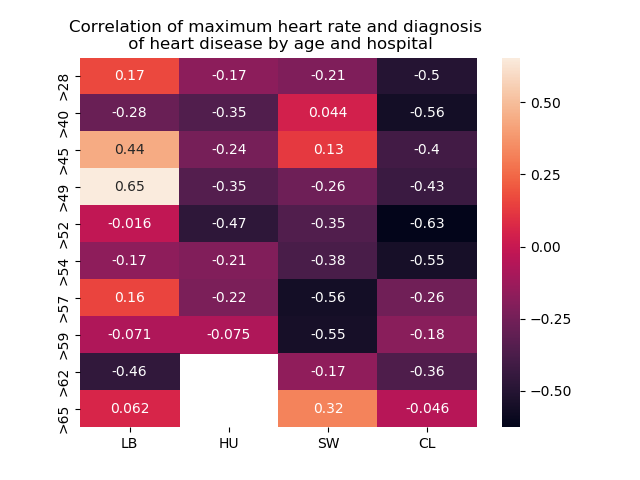

In [21]:
hospitals=['LB','HU','SW','CL'] #hospital list

columns=[]
for i in range(10): #10 iterations to define age partitions
    th_low=data['age'].quantile(q=i/10) #calculate thresholds
    th_high=data['age'].quantile(q=(i+1)/10)
    rows=[]
    for hosp in hospitals: #iterate over hospitals
        #for each age partition and hospital compute correlation matrix and select mhr to diag. append the result in a row
        rows.append(data[(data['hospital']==hosp) & (data['age']>th_low) 
                         & (data['age']<=th_high)].corr().loc['maximum heart rate','diagnosis of HD'])
        row=pd.DataFrame([rows]) #turn the row to dataframe
        row.set_axis(['>'+str(int(th_low))],axis=0) #set row label
    columns.append(row) #append the rows by columns

corr_data=pd.concat(columns) #turn columns in a dataframe
corr_data.set_axis(hospitals,axis=1) #set column names

%matplotlib notebook 
sns.heatmap(corr_data,annot=True) #plot the dataframe using heatmap
plt.title('Correlation of maximum heart rate and diagnosis \n of heart disease by age and hospital')
plt.show()

We can use `plot` functionality to easily plot this dataframe.

<IPython.core.display.Javascript object>


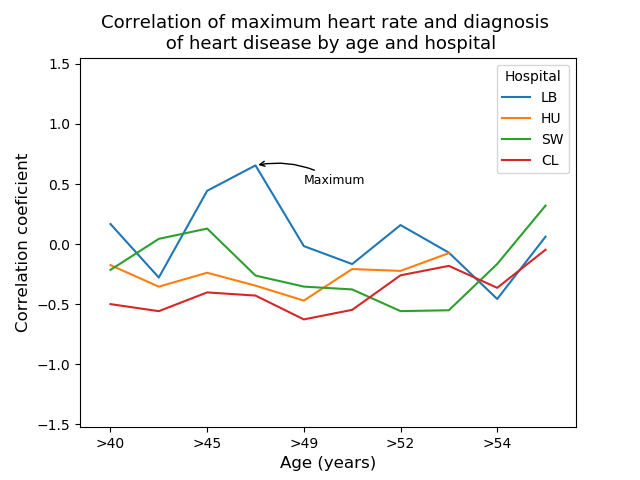

In [22]:
%matplotlib notebook
corr_data.plot() #plot correlation matrix and add title, labels and legend
plt.title('Correlation of maximum heart rate and diagnosis \n of heart disease by age and hospital',fontsize=13)
plt.xlabel('Age (years)',fontsize=12)
plt.ylabel('Correlation coeficient',fontsize=12)
plt.legend(title='Hospital')
plt.annotate("Maximum", xy=(3,corr_data.max().max()), xytext=(4,0.5), 
             fontsize=9,arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2",color='black'),color='black') #add annotation with fancy arrow
plt.margins(x=0.07,y=0.7) #wider margin
plt.autoscale(tight=False)
plt.show()

The same can be done for equally spaced age partitions. In this example, mean `maximum heart rate` is computed per hospital and age partition. However, it is worth mentioning that most patients are around age 40-60 so values within this range have more accurate mean values.

C:\Users\joana\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
C:\Users\joana\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.


<IPython.core.display.Javascript object>


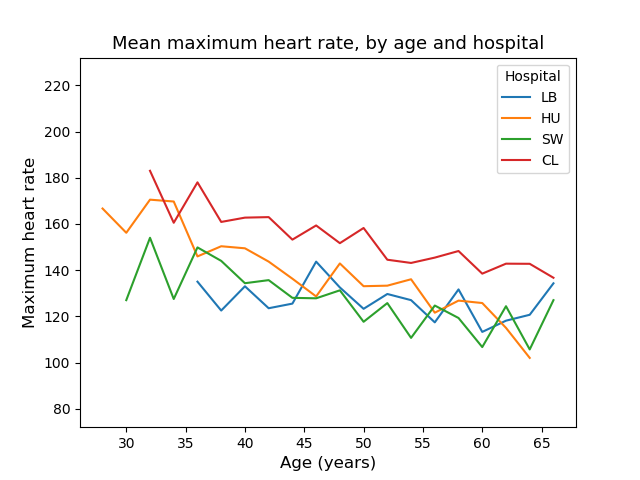

In [23]:
hospitals=['LB','HU','SW','CL'] #hospital list

columns=[]
min_age=data['age'].min()
max_age=data['age'].max()
delta=int(round((max_age-min_age)/20))

for i in range(20): #20 iterations to define age partitions
    th_low=min_age+delta*i #calculate thresholds
    th_high=min_age+delta*(i+1)
    rows=[]
    for hosp in hospitals: #iterate over hospitals
        #for each age partition and hospital compute correlation matrix and select mhr to diag. append the result in a row
        rows.append(data[(data['hospital']==hosp) & (data['age']>th_low) 
                         & (data['age']<=th_high)]['maximum heart rate'].mean())
        row=pd.DataFrame([rows]) #turn the row to dataframe
        row.set_axis([th_low],axis=0) #set row label
    columns.append(row) #append the rows by columns

mhr_data=pd.concat(columns) #turn columns in a dataframe
mhr_data.set_axis(hospitals,axis=1) #set column names

mhr_data.plot()
plt.title('Mean maximum heart rate, by age and hospital',fontsize=13)
plt.xlabel('Age (years)',fontsize=12)
plt.ylabel('Maximum heart rate',fontsize=12)
plt.legend(title='Hospital')
plt.annotate("Maximum", xy=(3,corr_data.max().max()), xytext=(4,0.5), 
             fontsize=9,arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2")) #add annotation with fancy arrow
plt.margins(x=0.05,y=0.3) #wider margin
plt.autoscale(tight=False)
plt.show()

A boxplot of the correlation dataframe is also generated using `seaborn`. Outliers are defined as those farther than $0.9 \sigma$. 

<IPython.core.display.Javascript object>


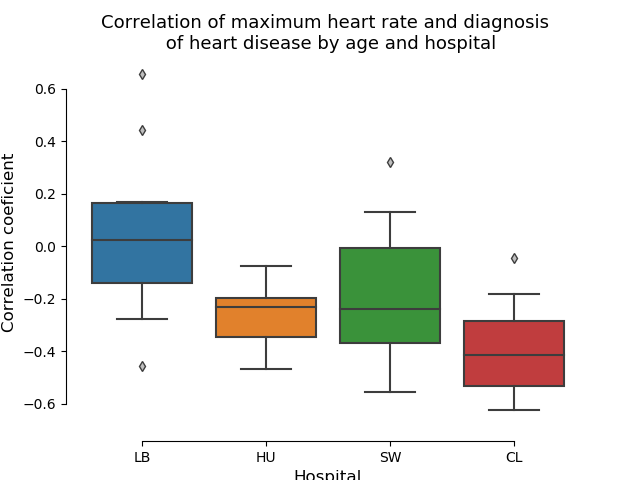

In [24]:
%matplotlib notebook

#define plot with nice oulier style
sns.boxplot(x="variable", y="value", data=pd.melt(corr_data),flierprops=dict(markerfacecolor='0.75', markersize=5,
              linestyle='none'),whis=0.9) 
sns.despine(offset=10, trim=True) #eliminate box surrounding plot

#set title and labels
plt.title('Correlation of maximum heart rate and diagnosis \n of heart disease by age and hospital',fontsize=13)
plt.xlabel('Hospital',fontsize=12)
plt.ylabel('Correlation coeficient',fontsize=12)
plt.show()

Similar to boxplots are violin plots, which show distribution rather than just quartiles. The following plot shows age distribution per hospital divided by sex, which allows us to visualize that data distribution is not homogeneous through hospitals. Quartiles are added as well.

<IPython.core.display.Javascript object>


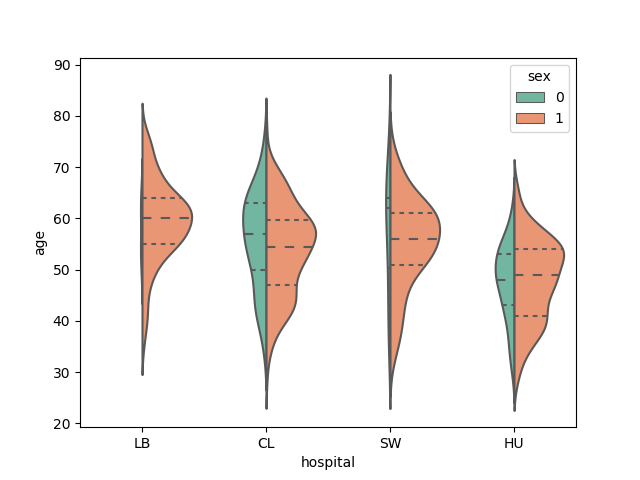

In [25]:
%matplotlib notebook
#violin plot displaying age distribution per hospital divided by sex. Quartiles added.
ax = sns.violinplot(x="hospital", y="age", hue="sex",
                    data=data, palette="Set2", split=True,
                    scale="count", inner="quartile")
plt.legend
plt.show()

Finally, it is interesting to see some scatter plots to understand the distribution of data and its variability. Scatter plots were already displayed earlier on grids but more options are explored here:

1. Class labels are increasing tones of purple and sizes, as the class variable shows increasing severity of heart disease.
2. Add trend line for each class. It can be seen that class 0 (no disease) shows different trend line.
3. Add kernel density estimation plots per variable, separated by class.

Ideally, these features could all be combined into one plot, but I have not found any intuitive way to do it. Would probably require to code it from scratch.

<IPython.core.display.Javascript object>


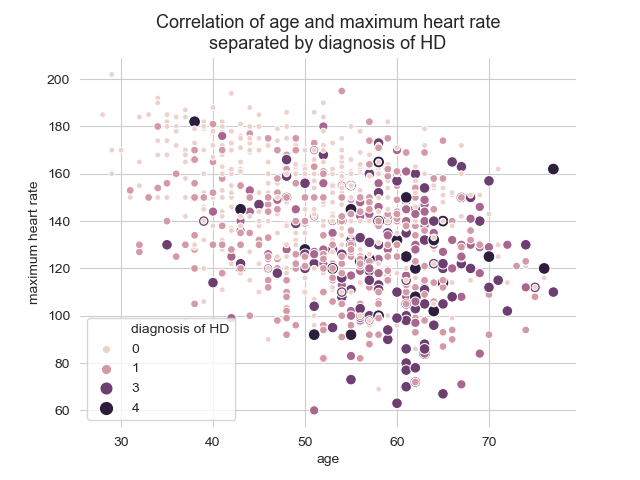

In [26]:
%matplotlib notebook
sns.set_style("whitegrid") #choose plotting style

#plot data, color and size treated continously depending on diagnosis
sns.scatterplot('age','maximum heart rate',hue='diagnosis of HD',size='diagnosis of HD',data=data)
plt.legend
plt.title('Correlation of age and maximum heart rate\nseparated by diagnosis of HD',fontsize=13)
sns.despine(left=True,bottom=True) #remove axis
plt.show()

<IPython.core.display.Javascript object>


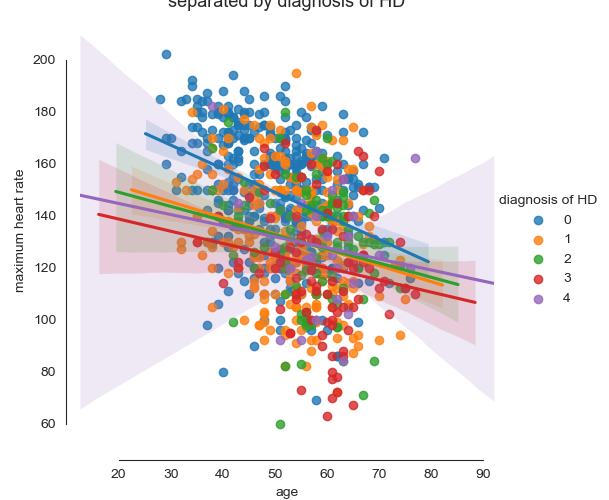

In [27]:
%matplotlib notebook
sns.set_style('white') #choose plotting style
sns.lmplot('age','maximum heart rate',hue='diagnosis of HD',data=data) #scatterplot with regression line
plt.legend
plt.title('Correlation of age and maximum heart rate\nseparated by diagnosis of HD',fontsize=13)
sns.despine(offset=10, trim=True) #fancier axis
plt.show()

<IPython.core.display.Javascript object>


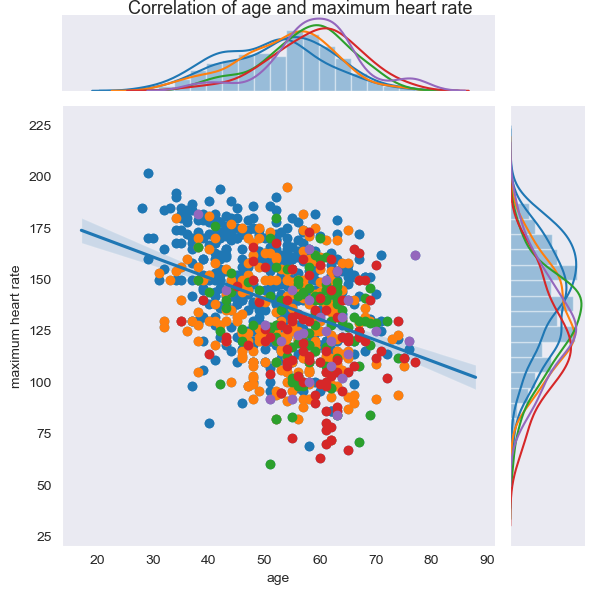

In [33]:
%matplotlib notebook
sns.set_style('dark') #choose plotting style
g = sns.jointplot(data['age'],data['maximum heart rate'], kind='reg') #initialise plot (reg-> trend line will be displayed)
for i, subdata in data.groupby("diagnosis of HD"): #one iteration for each class
    sns.kdeplot(subdata.loc[:,'age'], ax=g.ax_marg_x, legend=False) #add kde line for each class and variable (with different color)
    sns.kdeplot(subdata.loc[:,'maximum heart rate'], ax=g.ax_marg_y, vertical=True, legend=False)
    g.ax_joint.scatter(subdata['age'],subdata['maximum heart rate']) #add scatter plot of each class (same color as before)
plt.suptitle('\nCorrelation of age and maximum heart rate',fontsize=13,y=1.035)
plt.show()

# bokeh

`bokeh` is a really nice tool for making interactive plots. Inspired by a plot I saw online I created a stacked bar plot, where each bar is a hospital. Negative diagnosis (`0`) go to the left and positive diagnosis (`1` to `4`) to the right. This shows that data quality is not too high as some hospitals lack data (Switzerland and Long Beach data have almost no zeros, Hungary data has only zeros and ones), and hence this data could not be used for accurately training models.

In [20]:
output_file("bar_stacked_split.html") #define file

hospitals = ['LB','HU','SW','CL'] #create columns and classes
diagnosis_disease=['0','1','2','3','4']

df=[]
for hosp in hospitals: #create a dataframe with value counts for each diagnosis per hospital
    col=data[data['hospital']==hosp]['diagnosis of HD'].value_counts().sort_index()
    df.append(col)
diag_data=pd.concat(df,axis=1)
diag_data.columns=hospitals
diag_data['diag']=diagnosis_disease
diag_data=diag_data.set_index('diag')

hosps={'hospitals':hospitals}

#transpose dataframe and split it into healthy and disease
healthy_data=-diag_data.transpose().iloc[:,0].copy() #healthy goes negative as we want it to the left
healthy_data=healthy_data.to_list() #convert to dictionary (bokeh can also work with dataframes, but I managed easier this way)
healthy_data={**hosps,**{'0':healthy_data}}  

disease_data=diag_data.transpose().iloc[:,1:5].copy()
disease_data=disease_data.fillna(0).to_dict(orient='list')
disease_data={**hosps,**disease_data}

#create figure
p = figure(y_range=hospitals, plot_height=350, x_range=(-250, 250), title="Diagnosis of HD per hospital",
           x_axis_label='Number of patients',y_axis_label='Hospitals')

#add stacked plots
p.hbar_stack(['0'], y='hospitals', color = Spectral[11][0],height=0.9,  source=ColumnDataSource(healthy_data),
            legend='0 ')
p.hbar_stack(['1','2','3','4'], y='hospitals', color = Spectral[11][5:9],height=0.9,  source=ColumnDataSource(disease_data),
            legend=[i+' ' for i in ['1','2','3','4']])

p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_right" #legend characteristics
p.legend.title='Diagnosis'
p.axis.minor_tick_line_color = None
p.xaxis.major_label_overrides = {-i:str(i) for i in range(0,211,50)} #set neative labels positive
p.outline_line_color = None
p.axis.axis_label_text_font_size='14pt' #change label sizes
p.yaxis.major_label_text_font_size = "14pt"
p.xaxis.major_label_text_font_size = "10pt"

show(p)

For a more clear visualization we can do this comparison percentage wise. To do so, I normalized the value counts from 0 to 100 for each hospital and created a stacked area plot (ordered the hospitals first), where it can clearly be seen that distribution is very different for different hospitals. This type of plots are very nice when variable in x axis is ordinal, for instance, we could have age, but we've already seen that age distribution is not that good so results would not be accurate enough.

In [19]:
output_file('stacked_area.html')

hospitals = ['HU','CL','LB','SW'] #create columns and classes. Hospitals are ordered for better visualization
diagnosis_disease=['0','1','2','3','4']

df=[]
for hosp in hospitals: #create a dataframe with value counts for each diagnosis per hospital
    col=data[data['hospital']==hosp]['diagnosis of HD'].value_counts().sort_index()
    df.append(100*col/sum(col)) #normalize for each hospital value counts between 0 and 100
perc_data=pd.concat(df,axis=1)
perc_data.columns=hospitals
perc_data['diag']=diagnosis_disease
perc_data=perc_data.set_index('diag')

hosps={'hospitals':list(range(4))} #varea_stack needs x range to be ordinal, not categorical

#transpose dataframe and add hospitals list
perc_data=perc_data.transpose()
perc_data=perc_data.fillna(0).to_dict(orient='list') #set dictionary
perc_data={**hosps,**perc_data}

#create figure
p = figure(x_range=(0, 3), y_range=(0, 100),x_axis_label='Hospital',y_axis_label='% of diagnosis',
           title="Diagnosis of HD per hospital")

#create stacked area plot. x->hospitals, y->% of diagnosis
p.varea_stack(diagnosis_disease, x='hospitals',color=Spectral[11][6:11], 
              source=ColumnDataSource(perc_data),legend=[i+' ' for i in diagnosis_disease])

p.legend.location = "bottom_left" #set legend properties
p.legend.title='Diagnosis'
#change x labels so it displays hospitals, not numbers
p.xaxis.major_label_overrides = {(int(i/2) if i%2==0 else i/2):(hospitals[int(i/2)] if i%2==0 else ' ') for i in range(8)}
p.axis.axis_label_text_font_size='14pt' #change label sizes
p.xaxis.major_label_text_font_size = "14pt"
p.yaxis.major_label_text_font_size = "10pt"
p.axis.major_tick_line_color = None  # turn off major ticks
p.axis.minor_tick_line_color = None  # turn off minor ticks


show(p)